<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [0]:
import zipfile
import os

from pathlib import Path

for phase in ['train', 'valid', 'test']:
  if not Path(f'/content/drive/{phase}.zip').exists():     
    print(f'Downloading {phase}.zip')
    os.system(f'wget -nc https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/skin-cancer/{phase}.zip -P "/content/drive/"')
  if not Path(f'/content/drive/data/{phase}').exists(): 
    print(f'Extracting {phase}.zip')
    with zipfile.ZipFile(f'/content/drive/{phase}.zip', 'r') as myzip:
      myzip.extractall(path='/content/drive/data')

Extracting train.zip
Extracting valid.zip
Extracting test.zip


In [0]:
from google.colab import files
uploaded = files.upload()

Saving melanoma-1.zip to melanoma-1.zip
Saving melanoma-2.zip to melanoma-2.zip
Saving seborrheic_keratosis.zip to seborrheic_keratosis.zip


In [0]:
from google.colab import files
uploaded = files.upload()

Saving nevus.zip to nevus.zip


In [0]:
import zipfile
import io

for fn in uploaded.keys():
  zf = zipfile.ZipFile(io.BytesIO(uploaded[fn]), "r")
  zf.extractall('/content/drive/data/more/' + fn.split('.')[0].split('-')[0])

In [0]:
from os import listdir

for disease in ['melanoma', 'seborrheic_keratosis', 'nevus']:
  if os.path.exists('/content/drive/data/more/' + disease):
    files = [fn for fn in listdir('/content/drive/data/more/' + disease)]

    indices = list(range(len(files)))
    split = int(np.floor(0.7 * len(files)))

    np.random.shuffle(indices)

    train_idx, valid_idx = indices[split:], indices[:split]
    for idx in train_idx:
       os.system(f'mv /content/drive/data/more/{disease}/{files[idx]} /content/drive/data/train/{disease}/{files[idx]}')
    for idx in valid_idx:
       os.system(f'mv /content/drive/data/more/{disease}/{files[idx]} /content/drive/data/valid/{disease}/{files[idx]}')

FileNotFoundError: ignored

In [0]:
#!mv /content/drive/data/train/seborrheic_keratosis/seborrheic_keratosis /content/drive/data/more/seborrheic_keratosis

In [0]:
import os
import numpy as np
import pandas as pd
import torch
from torchvision import datasets
from tqdm import tqdm_notebook as tqdm
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
import torchvision.transforms as transforms
from torch.utils.data import SubsetRandomSampler

class ImageFolderWithPaths(datasets.ImageFolder):
    """Custom dataset that includes image file paths. Extends
    torchvision.datasets.ImageFolder
    """

    # override the __getitem__ method. this is the method dataloader calls
    def __getitem__(self, index):
        # this is what ImageFolder normally returns 
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        # the image file path
        path = self.imgs[index][0]
        # make a new tuple that includes original and the path
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path

### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes

# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 32

model_name = 'densenet'
image_size = 299 if model_name=='inception' else 224

transform = transforms.Compose([
                                transforms.Resize(image_size),
                                      transforms.CenterCrop(image_size),
                                #transforms.RandomResizedCrop(299),
                                transforms.RandomRotation(30),
                                #transforms.Lambda(lambda x : (x + torch.randn_like(x)) if random.random() < 0.2 else x),
                                #transforms.Resize(256),
                                      #transforms.CenterCrop(224),
                                transforms.RandomHorizontalFlip(),
                                transforms.RandomVerticalFlip(),
                                #transforms.RandomGrayscale(0.1),
                                #transforms.ColorJitter(brightness=0.4,contrast=0.4,saturation=0.4,hue=0.1),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])])

#specify a simpler transform for validation and test
test_transforms = transforms.Compose([transforms.Resize(image_size),
                                      transforms.CenterCrop(image_size),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

train_data_dir = '/content/drive/data/train'  
more_data_dir = '/content/drive/data/more'
validation_data_dir = '/content/drive/data/valid'  
test_data_dir = '/content/drive/data/test'

train_data = datasets.ImageFolder(train_data_dir, transform=transform)
#more_data = datasets.ImageFolder(more_data_dir, transform=transform)
valid_data = datasets.ImageFolder(validation_data_dir, transform=test_transforms)
test_data = ImageFolderWithPaths(test_data_dir, transform=test_transforms)

#final_train_data = torch.utils.data.ConcatDataset([train_data, more_data, valid_data])

#num_train = len(final_train_data)
#indices = list(range(num_train))
#split = int(np.floor(0.2 * num_train))

#np.random.shuffle(indices)

#train_idx, valid_idx = indices[split:], indices[:split]
#train_sampler = SubsetRandomSampler(train_idx)
#valid_sampler = SubsetRandomSampler(valid_idx)

# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, #sampler=train_sampler,
    num_workers=num_workers, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, #sampler=valid_sampler, 
    num_workers=num_workers, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
    num_workers=num_workers, shuffle=False)

loaders = {'train' : train_loader, 'valid': valid_loader, 'test': test_loader}

In [104]:
def print_data_statistics(): 
  target_names = [item for item in os.listdir(train_data_dir) if os.path.isdir(os.path.join(train_data_dir, item))]
  nb_train_samples = sum([len(files) for _, _, files in os.walk(train_data_dir)])  
  nb_more_samples = sum([len(files) for _, _, files in os.walk(more_data_dir)])  
  nb_validation_samples = sum([len(files) for _, _, files in os.walk(validation_data_dir)])
  nb_test_samples = sum([len(files) for _, _, files in os.walk(test_data_dir)])
  total_nb_samples = nb_train_samples + nb_validation_samples + nb_test_samples

  nb_classes = len(target_names)      # number of output classes

  print('Training a CNN Multi-Classifier Model ......')
  print('\n - names of classes: ', target_names, '\n - # of classes: ', nb_classes)
  print(' - # of trained samples: ', nb_train_samples,
        '\n - # of additional samples: ', nb_more_samples,
        '\n - # of validation samples: ', nb_validation_samples,
        '\n - # of test samples: ', nb_test_samples,
         '\n - total # of samples: ', total_nb_samples, '\n - train ratio:', round(nb_train_samples/total_nb_samples*100, 2),
        '\n - validation ratio:', round(nb_validation_samples/total_nb_samples*100, 2),
        '\n - test ratio:', round(nb_test_samples/total_nb_samples*100, 2))
  
print_data_statistics()

Training a CNN Multi-Classifier Model ......

 - names of classes:  ['melanoma', 'nevus', 'seborrheic_keratosis'] 
 - # of classes:  3
 - # of trained samples:  2000 
 - # of additional samples:  0 
 - # of validation samples:  150 
 - # of test samples:  600 
 - total # of samples:  2750 
 - train ratio: 72.73 
 - validation ratio: 5.45 
 - test ratio: 21.82


In [0]:
import itertools
import operator

def count_samples_per_class(data):
    data_grouped_by_class = itertools.groupby(data.samples, operator.itemgetter(1))
    idx_to_class = {v: k for k, v in data.class_to_idx.items()}
    for key, images in data_grouped_by_class:
        yield idx_to_class[key], len(list(images))

In [106]:
datas = {'train' : train_data, 'valid': valid_data, 'test': test_data}
#print([list(datas.keys()), 'Total'])
image_repartition = pd.DataFrame(index=datas.keys(), columns=train_data.classes)
#print(image_repartition)
for phase, data in datas.items():
    for disease, count in dict(count_samples_per_class(data)).items():
        image_repartition.loc[phase][disease]=count
    #print(f'{len(data)} images in {phase} set with the following repartition: {dict(count_samples_per_class(data))}')

#image_repartition = image_repartition.append(image_repartition.sum(numeric_only=True), ignore_index=True)
image_repartition['TOTAL'] = image_repartition.sum(axis=1)
image_repartition['Ratio'] = np.round(image_repartition.TOTAL / image_repartition.TOTAL.sum() * 100, 1)
print(image_repartition)

      melanoma nevus seborrheic_keratosis   TOTAL  Ratio
train      374  1372                  254  2000.0   72.7
valid       30    78                   42   150.0    5.5
test       117   393                   90   600.0   21.8


A single batch from the train set with data augmentation:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


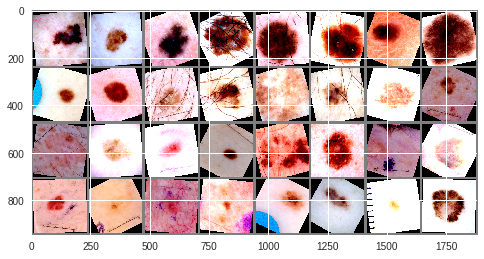

In [107]:
import torchvision
import matplotlib.pyplot as plt

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

print('A single batch from the train set with data augmentation:')
dataiter = iter(loaders['train'])
images, labels = dataiter.next()
imshow(torchvision.utils.make_grid(images, nrow=8, padding=10))

A single batch from the valid set with NO data augmentation:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


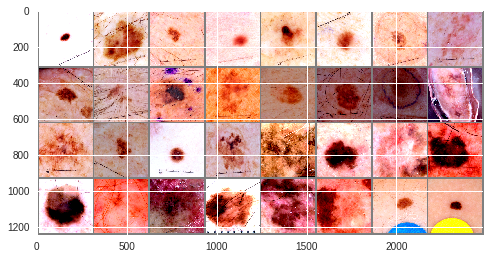

In [0]:

print('A single batch from the valid set with NO data augmentation:')
dataiter = iter(loaders['valid'])
images, labels = dataiter.next()
imshow(torchvision.utils.make_grid(images, nrow=8, padding=10))

In [0]:
import glob

def get_model_path(model_name, extension):
  i = 1
  while len(glob.glob(f'{model_name}_{i}*.{extension}')):
    i+=1
  return f'{model_name}_{i}.{extension}'

In [0]:
import logging

def init_log(log_file):
  rootLogger = logging.getLogger()
  rootLogger.handlers = []
  rootLogger.setLevel(logging.INFO)

  fileHandler = logging.FileHandler(log_file)
  fileHandler.terminator = '\r\n'
  rootLogger.addHandler(fileHandler)

  consoleHandler = logging.StreamHandler()
  rootLogger.addHandler(consoleHandler)

In [0]:
def train_model(model, model_name, dataloaders, criterion, optimizer, num_epochs=25, best_acc = 0.0):
    #https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html

    save_path = get_model_path(model_name, 'pt')
    init_log(save_path.replace('.pt', '.log'))
    
    logging.info(f'Start training {model_name} model with {criterion} and {optimizer}')
    since = time.time()

    train_acc_history = []
    val_acc_history = []
    
    best_model_wts = copy.deepcopy(model.state_dict())

    try:
        for epoch in range(1, num_epochs+1):
            logging.info('Epoch {}/{}'.format(epoch, num_epochs))
            logging.info('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'valid']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in tqdm(dataloaders[phase]):
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        # Get model outputs and calculate loss
                        # Special case for inception because in training it has an auxiliary output. In train
                        #   mode we calculate the loss by summing the final output and the auxiliary output
                        #   but in testing we only consider the final output.
                        if model_name=="inception" and phase == 'train':
                            # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                            outputs, aux_outputs = model(inputs)
                            loss1 = criterion(outputs, labels)
                            loss2 = criterion(aux_outputs, labels)
                            loss = loss1 + 0.4*loss2
                        else:
                            outputs = model(inputs)
                            loss = criterion(outputs, labels)

                        _, preds = torch.max(outputs, 1)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)

                epoch_loss = running_loss / len(dataloaders[phase].dataset)
                epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

                saving_model = '=> Saving model' if phase == 'valid' and epoch_acc > best_acc else ''
                logging.info(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} {saving_model}')

                # deep copy the model
                if phase == 'valid' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())                    
                    torch.save(model.state_dict(), save_path.replace('.', f'_{best_acc*100:.1f}.'))
                    #torch.save(model.state_dict(), save_path + '{:.3f}'.format(epoch_acc) + '.pt')
                if phase == 'train':
                    train_acc_history.append(epoch_acc)
                else:
                    val_acc_history.append(epoch_acc)

            logging.info('')
    
    except KeyboardInterrupt:
        logging.info('Training interrupted')
        pass
    
    time_elapsed = time.time() - since
    logging.info('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    logging.info('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, train_acc_history, val_acc_history

In [0]:
def test_model(loaders, model, criterion):

    # monitor test loss and accuracy
    running_loss = 0.0
    running_corrects = 0
    
    columns=['Id', 'task_1', 'task_2']
    probabilities = pd.DataFrame(columns=columns)

    model.eval()
    for inputs, labels, file_names in tqdm(loaders['test']):
        # move to GPU if any
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)            
            
            # statistics
            _, preds = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            
            probs = torch.nn.Softmax(dim=1)(outputs.data)
            probs = probs[:, [0,2]].cpu().numpy()
            probabilities = probabilities.append(
                pd.DataFrame({'Id': np.array([file_name[file_name.find('data')].replace('\\','/') for file_name in file_names]), 
                              'task_1': probs[:,0], 
                              'task_2': probs[:,1]}, columns=columns), ignore_index=True)
               
    epoch_loss = running_loss / len(loaders['test'].dataset)
    epoch_acc = running_corrects.double() / len(loaders['test'].dataset)
    
    logging.info(f'Test Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

    return probabilities.sort_values('Id')

In [0]:
import torchvision.models as models
import torch.nn as nn

In [0]:
import torchvision.models as models
import torch.nn as nn

## Specify model architecture 
model_transfer = models.densenet161(pretrained=True)
#print(model_transfer)

# Freeze training for all "features" layers
for param in model_transfer.parameters():
    param.requires_grad = False

n_inputs = model_transfer.classifier.in_features
#n_inputs = model_transfer.fc.in_features

#last_layer = nn.Sequential(nn.Dropout(0.25), nn.Linear(n_inputs, 3))
last_layer = nn.Linear(n_inputs, 3)

# new layers automatically have requires_grad = True
model_transfer.classifier = last_layer
#model_transfer.fc = last_layer

use_cuda = torch.cuda.is_available()
# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

if use_cuda:
    model_transfer = model_transfer.cuda()
        

/usr/local/lib/python3.6/dist-packages/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)


In [0]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [0]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet18
        """
        model_ft = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "alexnet":
        """ Alexnet
        """
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "squeezenet":
        """ Squeezenet
        """
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
        input_size = 224

    elif model_name == "densenet":
        """ Densenet
        """
        model_ft = models.densenet161(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "inception":
        """ Inception v3
        Be careful, expects (299,299) sized images and has auxiliary output
        """
        model_ft = models.inception_v3(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        # Handle the auxilary net
        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        # Handle the primary net
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs,num_classes)
        input_size = 299

    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size

In [0]:
feature_extract = True
num_classes = 3
model_transfer, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)
print(model_transfer)

/usr/local/lib/python3.6/dist-packages/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace)
        (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace)
        (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inpla

In [0]:
import torch.optim as optim
import time
import copy

# Send the model to GPU
model_transfer = model_transfer.to(device)

criterion_transfer = nn.CrossEntropyLoss()

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model_transfer.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_transfer.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_transfer.named_parameters():
        if param.requires_grad == True:
            print("\t",name)
            
optimizer_transfer = optim.Adam(params_to_update, lr=0.001)

Params to learn:
	 classifier.weight
	 classifier.bias


In [0]:
# load the model that got the best validation accuracy from previous training sessions
#if os.path.exists('inception_1_53.3.pt'):
#    model_transfer.load_state_dict(torch.load('inception_1_53.3.pt'))

# train the model
n_epochs=20
model_transfer, train_acc_history, val_acc_history = train_model(model_transfer, model_name, loaders, criterion_transfer, optimizer_transfer, num_epochs=n_epochs, best_acc=0.72)
#model_transfer = train(n_epochs, loaders, model_transfer, optimizer_transfer, criterion_transfer, use_cuda, 'model_transfer5.pt')

Start training densenet model with CrossEntropyLoss() and Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
)
Epoch 1/20
----------


In [82]:
# load the model that got the best validation accuracy from previous training sessions
#if os.path.exists('inception_1_53.3.pt'):
#    model_transfer.load_state_dict(torch.load('inception_1_53.3.pt'))

# train the model
n_epochs=20
model_transfer, train_acc_history, val_acc_history = train_model(model_transfer, model_name, loaders, criterion_transfer, optimizer_transfer, num_epochs=n_epochs, best_acc=0.72)
#model_transfer = train(n_epochs, loaders, model_transfer, optimizer_transfer, criterion_transfer, use_cuda, 'model_transfer5.pt')

Start training densenet model with CrossEntropyLoss() and Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
)
Epoch 1/14
----------


train Loss: 0.7437 Acc: 0.7020 


valid Loss: 0.7538 Acc: 0.6733 => Saving model

Epoch 2/14
----------


train Loss: 0.6294 Acc: 0.7445 


valid Loss: 0.7247 Acc: 0.6933 => Saving model

Epoch 3/14
----------


train Loss: 0.5949 Acc: 0.7510 


valid Loss: 0.6911 Acc: 0.7067 => Saving model

Epoch 4/14
----------


train Loss: 0.5746 Acc: 0.7680 


valid Loss: 0.7587 Acc: 0.6667 

Epoch 5/14
----------


train Loss: 0.5665 Acc: 0.7525 


valid Loss: 0.6759 Acc: 0.6733 

Epoch 6/14
----------


train Loss: 0.5356 Acc: 0.7805 


valid Loss: 0.6940 Acc: 0.6867 

Epoch 7/14
----------


train Loss: 0.5238 Acc: 0.7915 


valid Loss: 0.7091 Acc: 0.6867 

Epoch 8/14
----------


train Loss: 0.5177 Acc: 0.7840 


valid Loss: 0.7176 Acc: 0.7133 => Saving model

Epoch 9/14
----------


train Loss: 0.5179 Acc: 0.7840 


valid Loss: 0.7592 Acc: 0.6800 

Epoch 10/14
----------


train Loss: 0.4982 Acc: 0.8030 


valid Loss: 0.6781 Acc: 0.6867 

Epoch 11/14
----------


train Loss: 0.4927 Acc: 0.8005 


valid Loss: 0.6433 Acc: 0.6933 

Epoch 12/14
----------


train Loss: 0.4840 Acc: 0.8055 


valid Loss: 0.7507 Acc: 0.6800 

Epoch 13/14
----------


train Loss: 0.4877 Acc: 0.7960 


valid Loss: 0.6591 Acc: 0.6867 

Epoch 14/14
----------


train Loss: 0.4905 Acc: 0.7960 


valid Loss: 0.6583 Acc: 0.7200 => Saving model

Epoch 15/14
----------


train Loss: 0.4651 Acc: 0.8055 


valid Loss: 0.6743 Acc: 0.7133 

Training complete in 136m 40s
Best val Acc: 0.720000


In [90]:
predictions = test_model(loaders, model_transfer, criterion_transfer)

Test Loss: 0.7439 Acc: 0.6700


In [0]:
# load the model that got the best validation accuracy from previous training sessions
#if os.path.exists('model_transfer3.pt'):
#    model_transfer.load_state_dict(torch.load('model_transfer3.pt'))

# train the model
n_epochs=15
model_transfer, train_acc_history, val_acc_history = train_model(model_transfer, loaders, criterion_transfer, optimizer_transfer, 'model_transfer6.pt', num_epochs=n_epochs, is_inception=(model_name=="inception"))
#model_transfer = train(n_epochs, loaders, model_transfer, optimizer_transfer, criterion_transfer, use_cuda, 'model_transfer5.pt')

Epoch 1/14
----------



train Loss: 0.8949 Acc: 0.6615 



val Loss: 0.8715 Acc: 0.6533 Saving model
Saving model

Epoch 2/14
----------



train Loss: 0.6826 Acc: 0.7055 



val Loss: 0.8509 Acc: 0.5667 

Epoch 3/14
----------



train Loss: 0.6451 Acc: 0.7185 



val Loss: 0.7929 Acc: 0.6533 

Epoch 4/14
----------



train Loss: 0.6180 Acc: 0.7440 



val Loss: 0.7827 Acc: 0.6467 

Epoch 5/14
----------



train Loss: 0.6296 Acc: 0.7410 



val Loss: 0.7587 Acc: 0.6733 Saving model
Saving model

Epoch 6/14
----------



train Loss: 0.6069 Acc: 0.7600 



val Loss: 0.8148 Acc: 0.6267 

Epoch 7/14
----------



train Loss: 0.5982 Acc: 0.7485 



val Loss: 0.7677 Acc: 0.6733 

Epoch 8/14
----------



train Loss: 0.5984 Acc: 0.7400 



val Loss: 0.7818 Acc: 0.6600 

Epoch 9/14
----------



train Loss: 0.5967 Acc: 0.7440 



val Loss: 0.7573 Acc: 0.6667 

Epoch 10/14
----------



train Loss: 0.5821 Acc: 0.7580 



val Loss: 0.7517 Acc: 0.7067 Saving model
Saving model

Epoch 11/14
----------


Training interrupted
Training complete in 177m 9s
Best val Acc: 0.706667


In [0]:
#model_transfer.load_state_dict(torch.load('model_transfer6.pt'))

predictions = test_model(loaders, model_transfer, criterion_transfer)

Test Loss: 0.7170 Acc: 0.6850


In [0]:
# load the model that got the best validation accuracy from previous training sessions
#if os.path.exists('model_transfer3.pt'):
#    model_transfer.load_state_dict(torch.load('model_transfer3.pt'))

# train the model
n_epochs=15
model_transfer = train(n_epochs, loaders, model_transfer, optimizer_transfer, criterion_transfer, use_cuda, 'model_transfer4.pt')

Epoch: 1 	Training Loss: 0.885261 	Validation Loss: 0.968444
Validation loss decreased (inf --> 0.968444).  Saving model ...


Epoch: 2 	Training Loss: 0.708895 	Validation Loss: 0.844065
Validation loss decreased (0.968444 --> 0.844065).  Saving model ...


Epoch: 3 	Training Loss: 0.687421 	Validation Loss: 0.862602


Epoch: 4 	Training Loss: 0.668674 	Validation Loss: 0.849033


KeyboardInterrupt: 

In [0]:
# load the model that got the best validation accuracy from previous training sessions
if os.path.exists('model_transfer4.pt'):
    model_transfer.load_state_dict(torch.load('model_transfer4.pt'))

# train the model
n_epochs=15
model_transfer = train(n_epochs, loaders, model_transfer, optimizer_transfer, criterion_transfer, use_cuda, 'model_transfer4.pt', 0.844065)

Epoch: 1 	Training Loss: 0.742056 	Validation Loss: 0.871892


Epoch: 2 	Training Loss: 0.607893 	Validation Loss: 0.786069
Validation loss decreased (0.844065 --> 0.786069).  Saving model ...


Epoch: 3 	Training Loss: 0.555907 	Validation Loss: 0.795561


Epoch: 4 	Training Loss: 0.542843 	Validation Loss: 0.755493
Validation loss decreased (0.786069 --> 0.755493).  Saving model ...


Epoch: 5 	Training Loss: 0.515856 	Validation Loss: 0.766058


Epoch: 6 	Training Loss: 0.518616 	Validation Loss: 0.841451


Epoch: 7 	Training Loss: 0.502185 	Validation Loss: 0.788088


Epoch: 8 	Training Loss: 0.511876 	Validation Loss: 0.805269


KeyboardInterrupt: 

In [0]:
model_transfer.load_state_dict(torch.load('model_transfer4.pt'))

predictions = test(loaders, model_transfer, criterion_transfer, use_cuda)

Test Loss: 0.688541


Test Accuracy: 69% (415/600)


In [0]:
# load the model that got the best validation accuracy from previous training sessions
#if os.path.exists('model_transfer3.pt'):
#    model_transfer.load_state_dict(torch.load('model_transfer3.pt'))

# train the model
n_epochs=15
model_transfer = train(n_epochs, loaders, model_transfer, optimizer_transfer, criterion_transfer, use_cuda, 'model_transfer3.pt')

Epoch: 1 	Training Loss: 0.836597 	Validation Loss: 0.842026
Validation loss decreased (inf --> 0.842026).  Saving model ...


Epoch: 2 	Training Loss: 0.710520 	Validation Loss: 0.957469


KeyboardInterrupt: 

In [0]:
# load the model that got the best validation accuracy from previous training sessions
#if os.path.exists('model_transfer3.pt'):
#    model_transfer.load_state_dict(torch.load('model_transfer3.pt'))

# train the model
n_epochs=15
model_transfer = train(n_epochs, loaders, model_transfer, optimizer_transfer, criterion_transfer, use_cuda, 'model_transfer3.pt')

Epoch: 1 	Training Loss: 0.843254 	Validation Loss: 0.987324
Validation loss decreased (inf --> 0.987324).  Saving model ...


Epoch: 2 	Training Loss: 0.774487 	Validation Loss: 0.958315
Validation loss decreased (0.987324 --> 0.958315).  Saving model ...


KeyboardInterrupt: 

In [0]:
# load the model that got the best validation accuracy (uncomment the line below)
model_transfer.load_state_dict(torch.load('model_transfer3.pt'))

optimizer_transfer = optim.Adam(model_transfer.classifier.parameters(), lr=0.0003)
model_transfer = train(n_epochs, loaders, model_transfer, optimizer_transfer, criterion_transfer, use_cuda, 'model_transfer3.pt', 0.865868)

Epoch: 1 	Training Loss: 0.809144 	Validation Loss: 0.861169
Validation loss decreased (0.865868 --> 0.861169).  Saving model ...


Epoch: 2 	Training Loss: 0.743193 	Validation Loss: 0.911867


KeyboardInterrupt: 

In [0]:
model_transfer.load_state_dict(torch.load('model_transfer3.pt'))

predictions = test(loaders, model_transfer, criterion_transfer, use_cuda)
#predictions.to_csv('predictions2.csv')

Test Loss: 0.754682


Test Accuracy: 69% (414/600)


In [0]:
predictions = test(loaders, model_transfer, criterion_transfer, use_cuda)
predictions.to_csv('predictions.csv')























  0%|                                                                                           | 0/30 [00:00<?, ?it/s]





















  3%|██▊                                                                                | 1/30 [00:28<13:47, 28.52s/it]





















  7%|█████▌                                                                             | 2/30 [01:00<13:50, 29.67s/it]





















 10%|████████▎                                                                          | 3/30 [01:29<13:13, 29.39s/it]





















 13%|███████████                                                                        | 4/30 [02:00<12:59, 29.99s/it]





















 17%|█████████████▊                                                                     | 5/30 [02:43<14:06, 33.87s/it]





















 20%|████████████████▌                                                                  | 6/30 [03:22<14:07, 35.33s/it]














Test Loss: 0.672915


Test Accuracy: 72% (433/600)


In [0]:
predictions = predictions.as_matrix(columns=['task_1', 'task_2'])

In [0]:
def get_ground_truth():
    # get ground truth labels for test dataset
    truth = pd.read_csv('ground_truth.csv')
    y_true = truth.as_matrix(columns=["task_1", "task_2"])
    return y_true

In [0]:
def get_predictions():
    # get ground truth labels for test dataset
    truth = pd.read_csv('predictions.csv')
    y_true = truth.as_matrix(columns=["task_1", "task_2"])
    return y_true

In [0]:
def get_sample_predictions():
    truth = pd.read_csv('sample_predictions.csv')
    y_true = truth.as_matrix(columns=["task_1", "task_2"])
    return y_true

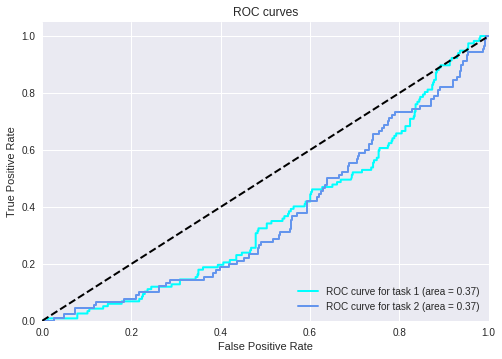

Category 1 Score: 0.374
Category 2 Score: 0.370
Category 3 Score: 0.372


In [97]:
from get_results import plot_roc_auc, plot_confusion_matrix

y_true = get_ground_truth()

plot_roc_auc(y_true, predictions)

In [0]:
def step(x, threshold=0):
    return np.sign(np.sign(x-threshold)+1)

def minimum_cost_threshold(y_true, y_pred, costs=(1, 1)):
    '''
    Find the decision threshold that minimizes the cost of errors.
    
    costs=(false_positive_cost, false_negative_cost)
    '''
    def error(x, costs):
        return costs[0]*step(-x, 0.99) + costs[1]*step(x,0.99)
    costs = np.array(costs)
    costs = costs/np.sum(costs)
    min_cost = np.inf
    min_threshold = 0
    for threshold in np.arange(0, 1, 0.001):
        y_pred_bin = np.ceil(y_pred - threshold)
#         cost = np.abs(y_true - y_pred_bin)*np.apply_along_axis(lambda i: costs[i[0]], 0, y_true)
        cost = error(y_true-y_pred_bin, costs)
        if np.mean(cost) < min_cost:
#             print(cost[:10])
            min_cost = np.mean(cost)
            min_threshold = threshold
    return min_threshold

def plot_best_confusion_matrix(y_true, y_pred, costs=(1,1)):
    threshold = minimum_cost_threshold(y_true, y_pred, costs=costs)
    print('Best threshold: %0.2f' % threshold)
    plot_confusion_matrix(y_true, y_pred, threshold, ['benign', 'malignant'])

Best threshold: 0.12


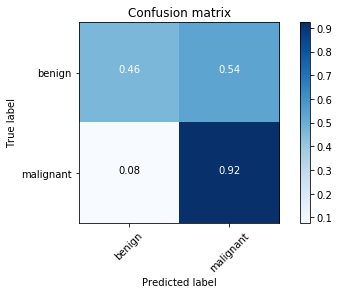

In [0]:
plot_best_confusion_matrix(y_true[:, 0], predictions[:, 0], costs=(1,10))

Best threshold: 0.14


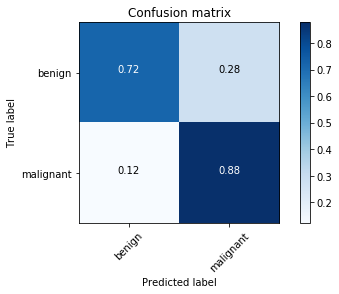

In [0]:
plot_best_confusion_matrix(y_true[:, 1], predictions[:, 1], costs=(1,10))

In [0]:
# load the model that got the best validation accuracy from previous training sessions
model_transfer.load_state_dict(torch.load('model_transfer2.pt'))

# train the model
n_epochs=15
model_transfer = train(n_epochs, loaders, model_transfer, optimizer_transfer, criterion_transfer, use_cuda, 'model_transfer2.pt')



  0%|                                                                                          | 0/100 [00:00<?, ?it/s]

  1%|▊                                                                                 | 1/100 [00:24<40:04, 24.29s/it]

  2%|█▋                                                                                | 2/100 [00:51<41:09, 25.20s/it]

  3%|██▍                                                                               | 3/100 [01:18<41:47, 25.85s/it]

  4%|███▎                                                                              | 4/100 [01:45<41:37, 26.02s/it]

  5%|████                                                                              | 5/100 [02:11<41:08, 25.99s/it]

  6%|████▉                                                                             | 6/100 [02:40<42:02, 26.83s/it]

  7%|█████▋                                                                            | 7/100 [03:07<41:53, 27.03s/it]

  8%|██████▌                  

Epoch: 1 	Training Loss: 0.654738 	Validation Loss: 0.750791
Validation loss decreased (inf --> 0.750791).  Saving model ...




  0%|                                                                                          | 0/100 [00:00<?, ?it/s]

  1%|▊                                                                                 | 1/100 [00:24<40:16, 24.40s/it]

  2%|█▋                                                                                | 2/100 [00:49<40:22, 24.72s/it]

KeyboardInterrupt: 

In [0]:
model_transfer.load_state_dict(torch.load('model_transfer2.pt'))

In [0]:
test(loaders, model_transfer, criterion_transfer, use_cuda)





  0%|                                                                                           | 0/30 [00:00<?, ?it/s]



  3%|██▊                                                                                | 1/30 [00:25<12:26, 25.75s/it]



  7%|█████▌                                                                             | 2/30 [00:52<12:10, 26.09s/it]



 10%|████████▎                                                                          | 3/30 [01:16<11:26, 25.43s/it]



 13%|███████████                                                                        | 4/30 [01:42<11:03, 25.50s/it]



 17%|█████████████▊                                                                     | 5/30 [02:09<10:48, 25.94s/it]



 20%|████████████████▌                                                                  | 6/30 [02:35<10:25, 26.08s/it]



 23%|███████████████████▎                                                               | 7/30 [03:01<09:57, 25.96s/it]



 27%|███████

Test Loss: 0.672915


Test Accuracy: 72% (433/600)
